In [44]:
import math 
import numpy as np
import pysindy as ps
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def bio(data, t):
    F = 5
    B = 1
    R = 3
    
    n = len(data)
    result = np.empty(n)
    
    for i in range(0,n):
        sigma = 0
        for j in range (0,n):
            sigma = sigma + R*(adjacency[i,j])*data[i]*data[j]
        result[i] = F - B*data[i] - sigma
    
    return result

In [3]:
library_functions = [
    lambda : 1,
    lambda x : x,
    lambda x,y : x*y
]
library_function_names = [
    lambda : 1,
    lambda x : x,
    lambda x,y : '' + x + '.' + y
]

"""
input:
    an array with len=number_of_nodes
output: 
    and array with len=len(custom_library.get_feature_names())
example:
    input = [0., 0., 1., 1,]
    output = [1, data[0], data[1], data[2], data[3], 
            data[0]*data[1], data[0]*data[2], data[0]*data[3],
            data[1]*data[2], data[1]*data[3], data[2]*data[3]]
"""
def library_parser(data):
    n = len(data)
    result = [None] * int(1 + n + n*(n-1)/2)
    result[0] = 1
    for i in range(0,n):
        result[i+1] = data[i]
    index = 0
    for i in range(0,n):
        for j in range(i+1,n):
            index += 1
            result[n+index] = data[i]*data[j]
    return result

In [6]:
number_of_nodes = 10
# graph = nx.erdos_renyi_graph(number_of_nodes, 0.2)
graph = nx.connected_watts_strogatz_graph(number_of_nodes, 4, 0.5)
# graph = nx.barabasi_albert_graph(number_of_nodes, int(number_of_nodes/5)) 
# graph = nx.scale_free_graph(number_of_nodes)
adjacency = nx.to_numpy_matrix(graph).A


In [8]:
dt = .01

t_train = np.arange(0, 100, dt)
x0_train = np.random.rand(number_of_nodes) * 10
x_train = odeint(bio, x0_train, t_train)

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -154668.934 1 + -975766.343 x0 + 2340426.665 x1 + -153239.158 x2 + 1303498.821 x3 + 552409.055 x4 + -858956.105 x5 + 687455.122 x6 + -556357.872 x7 + 98504.684 x8 + -898598.041 x9 + 597519.864 x0.x1 + 2381515.046 x0.x2 + -766333.739 x0.x3 + 1128838.733 x0.x4 + -557895.585 x0.x5 + 1254775.137 x0.x6 + -2132142.033 x0.x7 + -335373.962 x0.x8 + -50968.804 x0.x9 + -2315966.619 x1.x2 + -3424694.716 x1.x3 + -455532.071 x1.x4 + -886013.141 x1.x5 + 594581.587 x1.x6 + 2051616.032 x1.x7 + 35637.266 x1.x8 + -352808.241 x1.x9 + -2261839.542 x2.x3 + -267656.590 x2.x4 + 1252330.277 x2.x5 + -1428206.884 x2.x6 + 217286.328 x2.x7 + 1704742.228 x2.x9 + -1208277.066 x3.x4 + 225068.892 x3.x5 + 2473315.885 x3.x7 + 229560.982 x3.x8 + 1638115.696 x3.x9 + -329776.287 x4.x5 + 246350.513 x4.x6 + 36973.875 x4.x7 + 36610.889 x4.x8 + -35672.570 x4.x9 + 146543.045 x5.x6 + -76195.981 x5.x7 + -189103.003 x5.x8 + 1254852.660 x5.x9 + 234114.673 x6.x7 + 248101.197 x6.x8 + -1608245.362 x6.x9 + -42184.455 x7.x8 + -128

In [10]:
def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return state

real_steady_state = find_steady_state(x_train)        
        
def bio_sindy(data, t):
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

coefficients = model.coefficients()
x_test = odeint(bio_sindy, x0_train, t_train)
sindy_steady_state = find_steady_state(x_test)

print('real_steady_state:', real_steady_state)
print('sindy_steady_state:', sindy_steady_state)

real_steady_state: [0.36953735 0.4116211  1.00681322 0.38634878 0.89769451 0.68285888
 0.45419659 0.95760782 1.53315755 0.54130877]
sindy_steady_state: [0.36953735 0.4116211  1.00681322 0.38634878 0.89769451 0.68285888
 0.45419659 0.95760782 1.53315755 0.54130877]


In [11]:
def apply_perturbation(alpha, perturbed_node, steady_state, dynamic_func):
    perturbation = np.zeros(number_of_nodes)
    perturbation[perturbed_node] = steady_state[perturbed_node] * alpha
    perturbed = np.add(steady_state, perturbation)

    t_perturbed = np.arange(0, 100, dt)
    x_perturbed = odeint(dynamic_func, perturbed, t_perturbed)
    return x_perturbed

In [29]:
alpha = 0.5
perturbed_node = 8

x_train_perturbed = apply_perturbation(alpha, perturbed_node, real_steady_state, bio)
x_sindy_perturbed = apply_perturbation(alpha, perturbed_node, sindy_steady_state, bio_sindy)

In [30]:
perturbed_train_steady_state = find_steady_state(x_train_perturbed)
perturbed_sindy_steady_state = find_steady_state(x_sindy_perturbed)

print('perturbed_train_steady_state:', perturbed_train_steady_state)
print('perturbed_sindy_steady_state:', perturbed_sindy_steady_state)

perturbed_train_steady_state: [0.36954299 0.41164234 1.00669474 0.38634727 0.89767735 0.68285648
 0.45421639 0.95749008 1.53314765 0.54136256]
perturbed_sindy_steady_state: [0.37063973 0.41149044 1.00559148 0.38744705 0.89757182 0.68201282
 0.4541841  0.95767959 1.52407302 0.5413603 ]


In [31]:
def flow_diff(X):
    prev_state = X[0]
    result = np.empty((0,len(prev_state)))
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, diff))
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return result
    print('chaos state')
    return result

def flow(X):
    prev_state = X[0]
    result = [prev_state]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, state))
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return result
    print('chaos state')
    return result

x_train_flow = flow(x_train_perturbed)
x_sindy_flow = flow(x_sindy_perturbed)

In [34]:
def plot_flow(flow):
    fpr = 2
    plt.rcParams["figure.figsize"] = (16, 9)

    plt.figure(1)
    fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
    for i in range(0,number_of_nodes):
        axsi = axs[int(i/fpr), i%fpr]
        axsi.plot(flow[:,i])
        axsi.set_title('x'+str(i))
#         axsi.set_title('\u0394x'+str(i))
#         axsi.set_ylim(0.1,-0.1)

    plt.show()

<Figure size 1152x648 with 0 Axes>

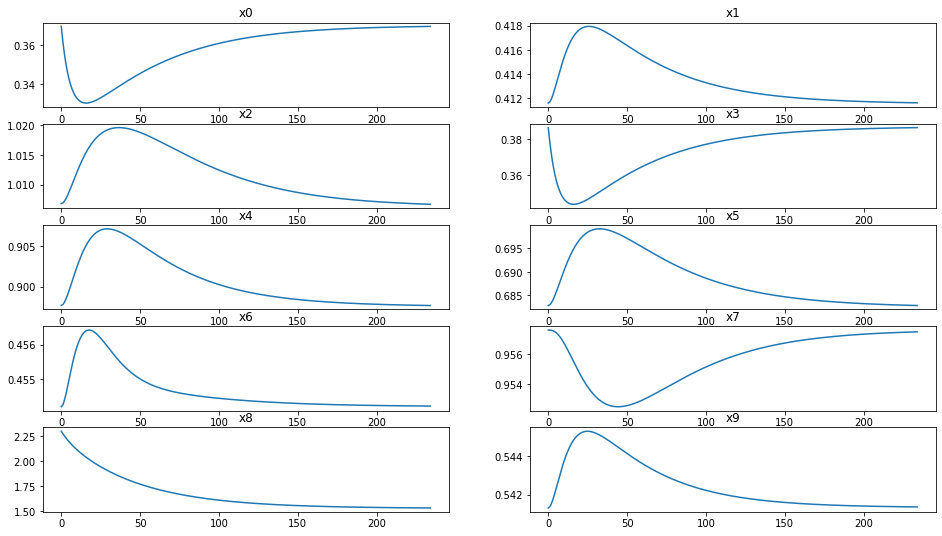

In [35]:
plot_flow(x_train_flow)

<Figure size 1152x648 with 0 Axes>

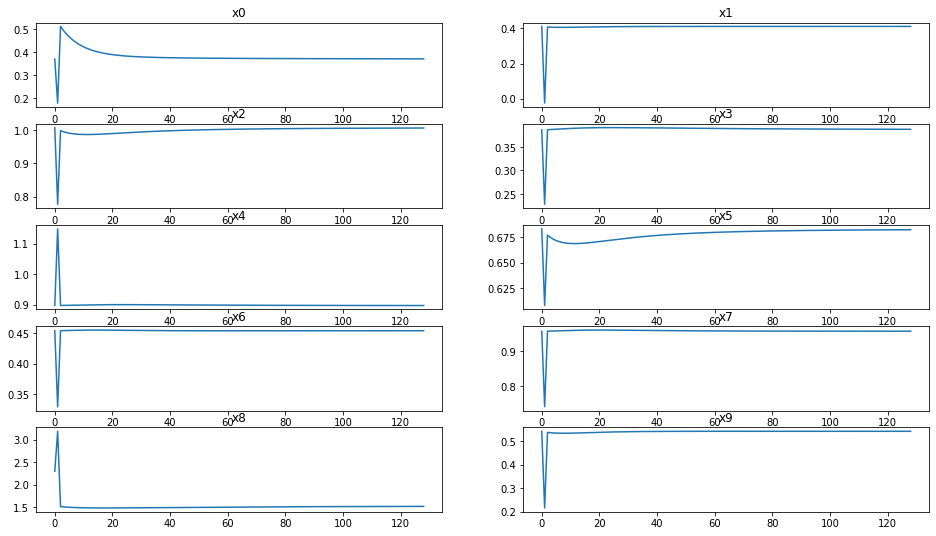

In [36]:
plot_flow(x_sindy_flow)

[(0, 5), (1, 6), (2, 3), (3, 5), (4, 3), (5, 4), (6, 5), (7, 3), (8, 2), (9, 4)]


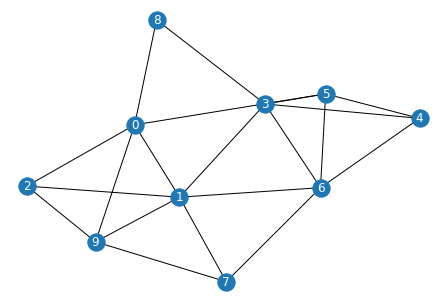

In [7]:
print(graph.degree)
nx.draw(graph, with_labels=True, font_color='white')

In [37]:
def calculate_g(alpha, steady_state, dynamic_func):
    g_matrix = np.empty((number_of_nodes,number_of_nodes))
    t_perturbed = np.arange(0, 10, dt)
    
    for i in range(0, number_of_nodes):
        perturbation_i = np.zeros(number_of_nodes)
        perturbation_i[i] = steady_state[i] * alpha
        perturbed_i = np.add(steady_state, perturbation_i[i])

        x_perturbed_i = odeint(dynamic_func, perturbed_i, t_perturbed)
        final_state_i = x_perturbed_i[-1]
        diff_i = np.subtract(final_state_i, steady_state)

        dxi_xi = diff_i[i]/steady_state[i]
        for j in range(0, number_of_nodes):
            dxj_xj = diff_i[j]/steady_state[j]
            g_matrix[i,j] = abs(dxi_xi/dxj_xj)
    
    return g_matrix

def find_g_dist(g_matrix):
    g_dist = []
    for row in g_matrix:
        for gij in row:
            g_dist.append(gij)
    return g_dist

In [39]:
g_matrix_train = calculate_g(alpha, real_steady_state, bio)
g_matrix_sindy = calculate_g(alpha, sindy_steady_state, bio_sindy)

# print(g_matrix_train)
# print(g_matrix_sindy)

<Figure size 1152x288 with 0 Axes>

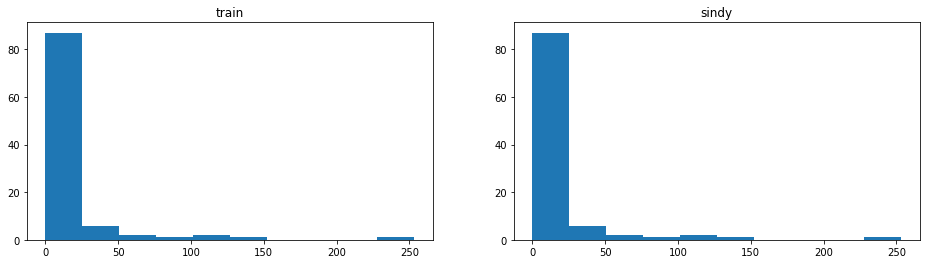

In [40]:
g_train_dist = find_g_dist(g_matrix_train)
g_sindy_dist = find_g_dist(g_matrix_sindy)

plt.rcParams["figure.figsize"] = (16, 4)
plt.figure(2)
fig, axs = plt.subplots(1, 2)
axs[0].hist(g_train_dist)
axs[0].set_title('train')
axs[1].hist(g_sindy_dist)
axs[1].set_title('sindy')
plt.show()

In [46]:
def calculate_f(g_matrix):
    f = np.zeros(number_of_nodes)
    logf = np.zeros(number_of_nodes)
    for i in range(0, number_of_nodes):
        f_i = np.zeros(number_of_nodes)
        for n in range(0, number_of_nodes):
            sum_gmn = 0
            for m in range(0, number_of_nodes):
                sum_gmn += g_matrix[m,n]
            sum_gmi = 0
            for m in range(0, number_of_nodes):
                if i==m:
                    continue
                sum_gmi += g_matrix[m,i]/sum_gmn
            f_i[n] = g_matrix[i,n] * sum_gmi

        for n in range(0, number_of_nodes):
            if i==n:
                continue
            f[i] += f_i[n]
        f[i] /= (number_of_nodes-1)
        logf[i] = math.log(f[i], graph.degree[i])
    
    return f, logf

In [48]:
f_train, logf_train = calculate_f(g_matrix_train)
f_sindy, logf_sindy = calculate_f(g_matrix_sindy)

print(f_train)
print(f_sindy)
print(logf_sindy)

[0.80162597 0.9763496  0.92624675 0.80533234 0.97698508 0.92553206
 0.99840856 0.99715631 0.59692145 0.99544117]
[0.801626   0.97634958 0.92624673 0.80533234 0.97698507 0.92553206
 0.99840861 0.99715728 0.59692145 0.99544106]
[-0.13738531 -0.01335814 -0.06973764 -0.13451917 -0.02119392 -0.05582257
 -0.00098958 -0.00259124 -0.74438701 -0.0032961 ]
